# I. Huấn luyện và đánh giá mô hình

## 1. Import thư viện và đọc dữ liệu

In [1262]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from preprocessing import fill_missing, one_hot_encoding, create_features_and_target

%matplotlib inline

In [1263]:
train = pd.read_csv("house_prices/train.csv")
test = pd.read_csv("house_prices/test.csv") # test set này k có SalePrice (ta cần dự đoán cho ra kết quả của cuộc thi)

## 2. Preprocessing

### 2.1. Kiểm tra missing data

In [1264]:
print(f"Tổng số missing data ban đầu trong training set: {train.isnull().sum().sum()}")
print(f"Tổng số missing data ban đầu trong test set: {test.isnull().sum().sum()}")

Tổng số missing data ban đầu trong training set: 7829
Tổng số missing data ban đầu trong test set: 7878


### 2.2. Điền missing data

In [1265]:
train = fill_missing(train)
test = fill_missing(test)

In [1266]:
print(f"Tổng số missing data hiện tại trong training set: {train.isnull().sum().sum()}")
print(f"Tổng số missing data hiện tại trong test set: {test.isnull().sum().sum()}")

Tổng số missing data hiện tại trong training set: 0
Tổng số missing data hiện tại trong test set: 0


### 2.3. Căn chỉnh cột cho training set và test set

In [1267]:
train, test = one_hot_encoding(train, test)

### 2.4. Chia features và target

In [1268]:
X_full_train, y_full_train = create_features_and_target(train)

### 2.5. Feature Scaling

In [1269]:
# Lưu lại tên cột để convert lại về dạng data_frames sau
features_names = X_full_train.columns

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # chuyển dữ liệu về dạng 'numpy.ndarray'

X_full_train = scaler.fit_transform(X_full_train)

### 2.6. Từ training set tạo cross-validation set và test set dùng để đánh giá mô hình

In [1270]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [1271]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_cv.shape:    {X_cv.shape}')
print(f'X_test.shape:  {X_test.shape}')

X_train.shape: (876, 304)
X_cv.shape:    (292, 304)
X_test.shape:  (292, 304)


## 3. Huấn luyện và đánh giá mô hình

### 3.1. Khởi tạo và huấn luyện mô hình

In [1272]:
from sklearn.linear_model import LinearRegression

# Train
model = LinearRegression() # fx = wx+b
model.fit(X_train, y_train)

LinearRegression()

### 3.2. Tạo dự đoán của mô hình (+relu cho thực tế)

In [1273]:
# Predict (+ use relu)
y_pred_train = np.maximum(0, model.predict(X_train))
y_pred_cv = np.maximum(0, model.predict(X_cv))
y_pred_test = np.maximum(0, model.predict(X_test))

### 3.3. Tính cost của model (dùng root mean square error)

In [1274]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# RMSE - do giá nhà có đơn vị rõ ràng và lớn
train_rmse = sqrt(mean_squared_error(y_pred_train, y_train))
cv_rmse = sqrt(mean_squared_error(y_pred_cv, y_cv))
test_rmse = sqrt(mean_squared_error(y_pred_test, y_test))

print(f"Train RMSE:  {train_rmse}")
print(f"CV RMSE:     {cv_rmse}")
print(f"Test RMSE:   {test_rmse}")

# MSE của train quá lớn -> high bias
# MSE của train << MSE của test -> high variances

Train RMSE:  17188.550115225367
CV RMSE:     28405.30221595741
Test RMSE:   33119.765040955426


### 3.4. Visualizize model để xem mô hình hoạt động có ổn không 

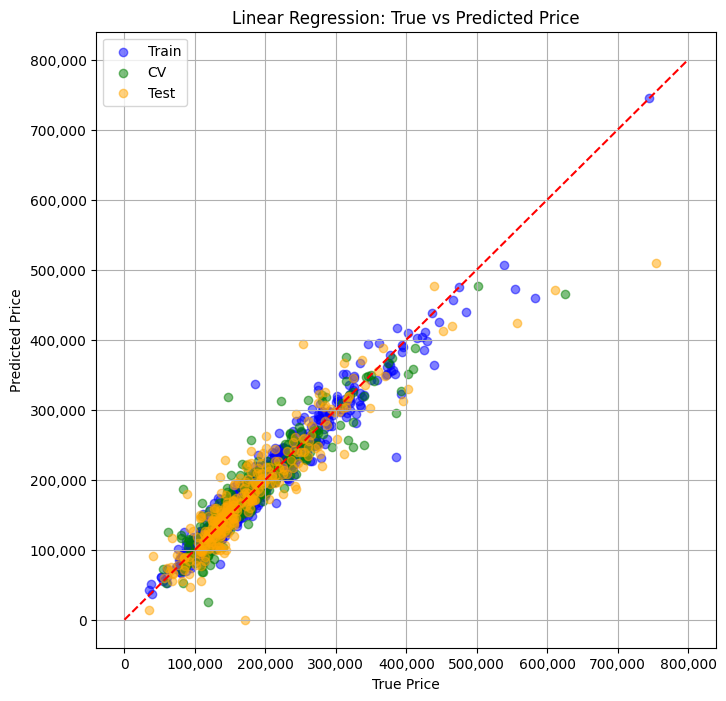

In [1275]:
import matplotlib.ticker as ticker
# Plot true vs predicted
plt.figure(figsize=(8, 8)) # tạo biểu đồ có tỷ lệ 8x8 inch

plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5, label='Train')
plt.scatter(y_cv, y_pred_cv, color='green', alpha=0.5, label='CV')
plt.scatter(y_test, y_pred_test, color='orange', alpha=0.5, label='Test')
# dùng biểu đồ tán xạ (scatter plot)
# ~ .scatter(x, y, alpha=?)
# ~ alpha=0.6: làm điểm trong suốt một chút -> dễ nhìn khi trùng nhau

plt.plot([0, 800000], [0, 800000], 'r--')
# Vẽ đường chéo lý tưởng mà trên đó mọi điểm (True Price, Predicted Price) sẽ nằm nếu mô hình dự đoán hoàn toàn chính xác.
# Khi mà Pridicted Price (trục y) == True Price (trục x)
# ~ plt.plot(x, y, style)
# ~ x: x1, x2 (ở đây là [0, 800000]) # có thể dùng [y_cv.min(), y_cv.max()]
# ~ y: y1, y2 (ở đây là [0, 800000])
# ~ -> (x1, y1) = (0, 0)
# ~ -> (x2, y2) = (800000, 800000)
# ~ => đường 45*
#
# ~ 'r--': 'r': màu đỏ (red) + '--': kiểu đường gạch đứt đoạn

plt.xlabel('True Price')
plt.ylabel('Predicted Price')
# Đặt tên trục x và y

# Tắt số dạng khoa học cho trục y và x
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y):,}'))
# plt.gca()
# → "Get current axis"
# → Lấy cái biểu đồ hiện tại đang vẽ (cụ thể là axes để chỉnh sâu hơn)
#
# .xaxis.set_major_formatter(...)
# → Cài lại cách hiển thị số ở trục X.
# → Tương tự cho .yaxis là trục Y.
#
# ticker.FuncFormatter(...)
# → Tạo 1 hàm custom để format số theo ý bạn.
# → Bạn truyền vào 1 hàm lambda.
#
# lambda x, _: f'{int(x):,}'
# → Hàm này nhận số x (số trên trục), rồi:
# int(x): ép thành số nguyên (khỏi lẻ).
# :,: format có dấu phẩy ngăn cách hàng nghìn.
# Ví dụ: 3557600 → "3,557,600"
# → _ là tham số bắt buộc thứ 2 mà FuncFormatter yêu cầu, nhưng ta không dùng tới nên đặt _.

plt.legend()
# Chú thích (theo label)

plt.title('Linear Regression: True vs Predicted Price')
# Đặt tên biểu đồ 

plt.grid(True)
# Hiện lưới nền trên biểu đồ -> giúp dễ đọc số liệu hơn

plt.show()

# II. Nâng cấp mô hình

## 1. Feature Engineering

Làm lại từ bước đầu với data_set train, đang mặc kệ test_set

### 1.1. Tạo thêm feature tương tác

In [1276]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
train['TotalBathrooms'] = train['FullBath'] + 0.5 * train['HalfBath']
train['HasBasement'] = (train['TotalBsmtSF'] > 0).astype(int) # chuyển về binary

### 1.2. Biến đổi dạng log các feature lệch (skewed features)

In [1277]:
# Chỉnh riêng cho 'SalePrice'
train["SalePrice"] = np.log1p(train["SalePrice"])

In [1278]:
# Dùng hàm skew trong thư viện để kiểm tra độ lệch do các outliners của từng cột
from scipy.stats import skew

numeric_feats = train.select_dtypes(include=[np.number]) 
# .select_dtypes(include=[np.number]): chọn tất cả các cột kiểu số (int, float, v.v.).

non_binary_feats = [col for col in numeric_feats.columns if train[col].nunique() > 2 and col != 'SalePrice']
# train[col].nunique() đếm số lượng giá trị duy nhất trong cột col.

skewness = train[non_binary_feats].apply(lambda x: skew(x.dropna()))
# .dropna() để chắc chắn k có biến nào bị thiếu cả

skewed_feats = skewness[skewness > 0.75]

# Chuyển các số ở đây về dạng log để giảm tác động của outliners
train[skewed_feats.index] = np.log1p(train[skewed_feats.index])

### 1.3. Biến số rời rạc thành category

In [1279]:
# Các cột như 'OverallQual': chạy theo 1 2 3 4 5 ... thì chuyển sang dạng str để one-hot encoding
train["OverallQual_cat"] = train["OverallQual"].astype(str)
train["OverallCond_cat"] = train["OverallCond"].astype(str)

In [1280]:
train, test = one_hot_encoding(train, test)

# Những cột này không cần nữa
train.drop(["OverallQual", "OverallCond"], axis=1, inplace=True)

### 1.4. Suy luận từ năm xây nhà

In [1281]:
train["HouseAge"] = np.maximum(0, train["YrSold"] - train["YearBuilt"])
train["RemodAge"] = np.maximum(0, train["YrSold"] - train["YearRemodAdd"])
train["GarageAge"] = np.maximum(0, train["YrSold"] - train["GarageYrBlt"])

### 1.5. Chạy lại Mô hình

In [1282]:
# Y sẽ ở dạng log 
X_full_train, y_full_train = create_features_and_target(train)

In [1283]:
features_names = X_full_train.columns

scaler = StandardScaler() # chuyển dữ liệu về dạng 'numpy.ndarray'

X_full_train = scaler.fit_transform(X_full_train)

In [1284]:
X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [1285]:
model = LinearRegression() # fx = wx+b
model.fit(X_train, y_train)

LinearRegression()

In [1286]:
# K cần cả relu vì dùng log rồi
# Đây là y_predict ở dạng log
y_pred_log_train = model.predict(X_train)
y_pred_log_cv = model.predict(X_cv)
y_pred_log_test = model.predict(X_test)

In [1287]:
# y đang ở dạng log nên cần chuyển lại ngược về ban đầu
y_pred_original_train = np.expm1(y_pred_log_train)
y_pred_original_cv = np.expm1(y_pred_log_cv)
y_pred_original_test = np.expm1(y_pred_log_test)

In [1288]:
y_train = np.expm1(y_train)
y_cv = np.expm1(y_cv)
y_test = np.expm1(y_test)

In [1289]:
train_rmse = sqrt(mean_squared_error(y_pred_original_train, y_train))
cv_rmse = sqrt(mean_squared_error(y_pred_original_cv, y_cv))
test_rmse = sqrt(mean_squared_error(y_pred_original_test, y_test))

# Có thể thấy RMSE giảm 
print(f"Train RMSE:  {train_rmse}")
print(f"CV RMSE:     {cv_rmse}")
print(f"Test RMSE:   {test_rmse}")

Train RMSE:  13674.415262685436
CV RMSE:     23453.02384438844
Test RMSE:   27505.25073269249


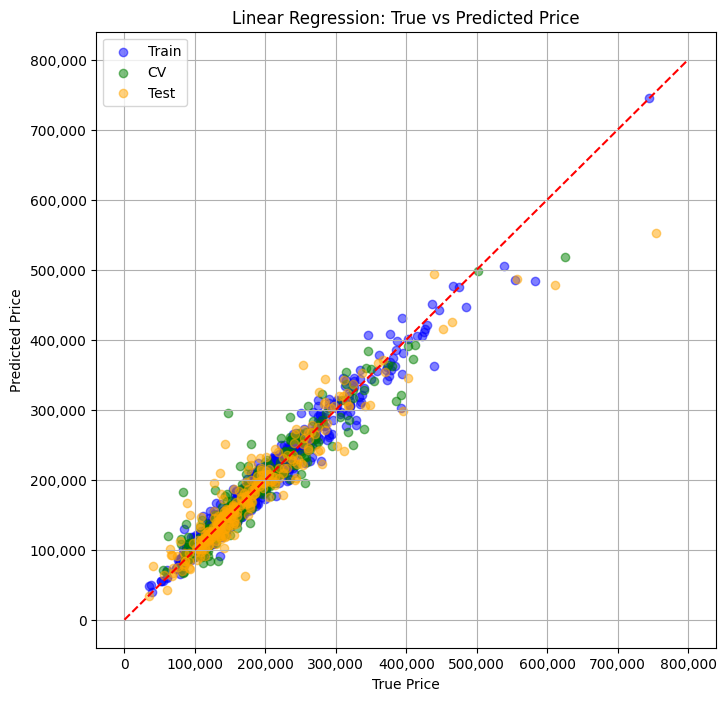

In [1290]:
plt.figure(figsize=(8, 8)) 

plt.scatter(y_train, y_pred_original_train, color='blue', alpha=0.5, label='Train')
plt.scatter(y_cv, y_pred_original_cv, color='green', alpha=0.5, label='CV')
plt.scatter(y_test, y_pred_original_test, color='orange', alpha=0.5, label='Test')

plt.plot([0, 800000], [0, 800000], 'r--')

plt.xlabel('True Price')
plt.ylabel('Predicted Price')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y):,}'))


plt.legend()

plt.title('Linear Regression: True vs Predicted Price')

plt.grid(True)

plt.show()

## 2. Thay đổi degree của mô hình

### 2.1. Lại preprocessing

In [1291]:
train.shape # 1460 rows, 328 columns

(1460, 328)

In [1292]:
X_full_train, y_full_train = create_features_and_target(train)

In [1293]:
X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### 2.2. Import các hàm 

In [1294]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

### 2.3. Scale dữ liệu

In [1295]:
# Scale dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

### 2.4. Chọn top K feature quan trọng nhất

In [1296]:
# Giữ lại 25 feature quan trọng nhất
k = 25
selector = SelectKBest(score_func=f_regression, k=k)
# selector = SelectKBest(score_func=f_regression, k=k)
# ~ SelectKBest là một phương pháp lọc feature (feature selection).
# ~ score_func=f_regression: tính toán mối quan hệ giữa từng feature và biến mục tiêu (y_train) dựa trên F-test (kiểm định thống kê tuyến tính).
# ~ Mỗi feature sẽ được chấm điểm → chọn ra 25 feature có điểm cao nhất.

X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_cv_selected = selector.transform(X_cv_scaled)
X_test_selected = selector.transform(X_test_scaled)

### 2.3. Chạy thử 4 degree đầu

In [1297]:
#Loop qua các degree của PolynomialFeatures
for deg in range(1, 5):
    model = make_pipeline(
        PolynomialFeatures(degree=deg, include_bias=False),
        LinearRegression()
    )

    # Fit model
    model.fit(X_train_selected, y_train)

    # Predict
    y_train_pred = model.predict(X_train_selected)
    y_cv_pred = model.predict(X_cv_selected)
    y_test_pred = model.predict(X_test_selected)

    # RMSE (phải chuyển ngược lại từ log)
    train_rmse = sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred)))
    cv_rmse = sqrt(mean_squared_error(np.expm1(y_cv), np.expm1(y_cv_pred)))
    test_rmse = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred)))

    print(f"Degree {deg}: Train RMSE = {train_rmse:.2f} || CV RMSE = {cv_rmse:.2f} || Test RMSE = {test_rmse:.2f}")

Degree 1: Train RMSE = 33466.18 || CV RMSE = 31578.49 || Test RMSE = 34259.75
Degree 2: Train RMSE = 18475.26 || CV RMSE = 78275.73 || Test RMSE = 49655.26
Degree 3: Train RMSE = 537.72 || CV RMSE = 10643016613.61 || Test RMSE = 5581469156.06
Degree 4: Train RMSE = 537.72 || CV RMSE = 36463814355.47 || Test RMSE = 200443094.04


Model ngày càng overfit 

=> GIỮ NGUYÊN MODEL BAN ĐẦU

## 3. Thêm regularization (dùng Ridge: $\sum w^2$) vào mô hình

In [1298]:
X_full_train, y_full_train = create_features_and_target(train)

X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [1299]:
from sklearn.linear_model import Ridge

# Scale dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)


lambdas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
for lmd in lambdas:
    
    #model = make_pipeline(
    #    PolynomialFeatures(degree=1, include_bias=False),
    #    Ridge(alpha=lmd) # Ridge = LinearRegression + regularization L2.
    #)
    model = Ridge(alpha=lmd)

    # Fit model
    model.fit(X_train_scaled, y_train)

    # Predict
    y_train_pred = model.predict(X_train_scaled)
    y_cv_pred = model.predict(X_cv_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # RMSE (phải chuyển ngược lại từ log)
    train_rmse = sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred)))
    cv_rmse = sqrt(mean_squared_error(np.expm1(y_cv), np.expm1(y_cv_pred)))
    test_rmse = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred)))

    print(f"Degree 1 + Lambda {lmd}: Train RMSE = {train_rmse:.2f} || CV RMSE = {cv_rmse:.2f} || Test RMSE = {test_rmse:.2f}")

Degree 1 + Lambda 0.001: Train RMSE = 14557.87 || CV RMSE = 24258.21 || Test RMSE = 27606.19
Degree 1 + Lambda 0.003: Train RMSE = 15039.37 || CV RMSE = 24466.00 || Test RMSE = 27446.25
Degree 1 + Lambda 0.01: Train RMSE = 15350.92 || CV RMSE = 24553.41 || Test RMSE = 27222.68
Degree 1 + Lambda 0.03: Train RMSE = 15482.75 || CV RMSE = 24571.18 || Test RMSE = 27163.66
Degree 1 + Lambda 0.1: Train RMSE = 15539.05 || CV RMSE = 24561.20 || Test RMSE = 27162.79
Degree 1 + Lambda 0.3: Train RMSE = 15558.01 || CV RMSE = 24527.61 || Test RMSE = 27141.79
Degree 1 + Lambda 1: Train RMSE = 15570.27 || CV RMSE = 24462.29 || Test RMSE = 27049.13
Degree 1 + Lambda 3: Train RMSE = 15592.82 || CV RMSE = 24373.02 || Test RMSE = 26830.97
Degree 1 + Lambda 10: Train RMSE = 15695.30 || CV RMSE = 24239.49 || Test RMSE = 26387.29
Degree 1 + Lambda 30: Train RMSE = 16009.35 || CV RMSE = 24152.73 || Test RMSE = 25939.93
Degree 1 + Lambda 100: Train RMSE = 17018.18 || CV RMSE = 24382.37 || Test RMSE = 26031.97

Degree 2 bị overfit nặng

=> Degree 1 là hợp lí nhất

Từ trên chọn đuọc lambda = 30

=>> Degree 1 + Lambda 30: Train RMSE = 16009.35 || CV RMSE = 24152.73 || Test RMSE = 25939.93

# 4. Ghép tất cả lại ra mô hình cuối

In [1300]:
X_full_train, y_full_train = create_features_and_target(train)

In [1301]:
X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [1302]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

In [1303]:
model = Ridge(alpha=30)
model.fit(X_train_scaled, y_train)

Ridge(alpha=30)

In [1304]:
y_pred_log_train = model.predict(X_train_scaled)
y_pred_log_cv = model.predict(X_cv_scaled)
y_pred_log_test = model.predict(X_test_scaled)

y_pred_original_train = np.expm1(y_pred_log_train)
y_pred_original_cv = np.expm1(y_pred_log_cv)
y_pred_original_test = np.expm1(y_pred_log_test)

y_train = np.expm1(y_train)
y_cv = np.expm1(y_cv)
y_test = np.expm1(y_test)

train_rmse = sqrt(mean_squared_error(y_train, y_pred_original_train))
cv_rmse = sqrt(mean_squared_error(y_cv, y_pred_original_cv))
test_rmse = sqrt(mean_squared_error(y_test, y_pred_original_test))

print(f"Final model: Degree 1, Lambda 30 \nTrain RMSE = {train_rmse:.2f} || CV RMSE = {cv_rmse:.2f} || Test RMSE = {test_rmse:.2f}")

Final model: Degree 1, Lambda 30 
Train RMSE = 16009.35 || CV RMSE = 24152.73 || Test RMSE = 25939.93


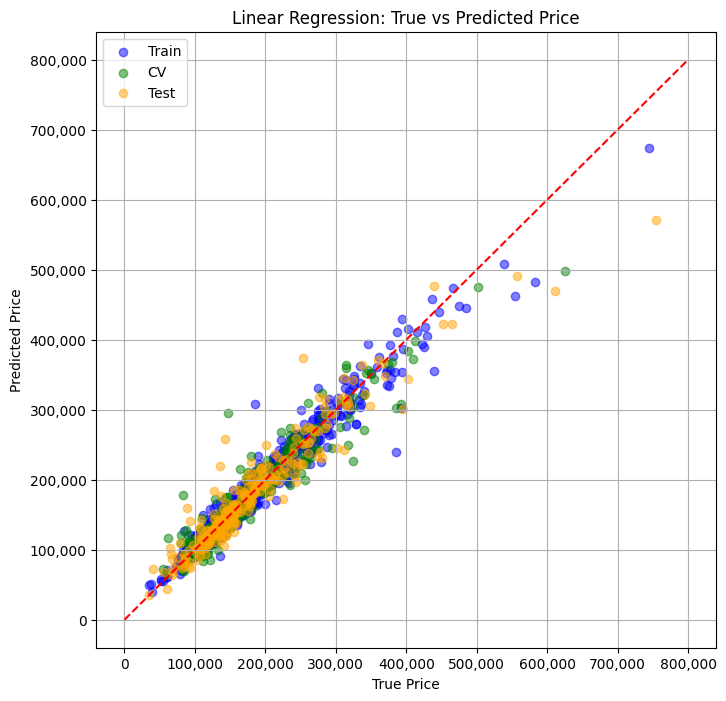

In [1305]:
plt.figure(figsize=(8, 8)) 

plt.scatter(y_train, y_pred_original_train, color='blue', alpha=0.5, label='Train')
plt.scatter(y_cv, y_pred_original_cv, color='green', alpha=0.5, label='CV')
plt.scatter(y_test, y_pred_original_test, color='orange', alpha=0.5, label='Test')

plt.plot([0, 800000], [0, 800000], 'r--')

plt.xlabel('True Price')
plt.ylabel('Predicted Price')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y):,}'))


plt.legend()

plt.title('Linear Regression: True vs Predicted Price')

plt.grid(True)

plt.show()